In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append("../../")

import pickle
import geopandas as gpd
from pathlib import Path
import getpass
from sklearn.preprocessing import StandardScaler

from povertymapping.rollout_grids import get_region_filtered_bingtile_grids 
from povertymapping import settings, nightlights
from povertymapping.iso3 import get_iso3_code
from povertymapping.dhs import generate_dhs_cluster_level_data
from povertymapping.feature_engineering import generate_features, categorize_wealth_index

/home/jace/workspace/unicef-ai4d-poverty-mapping/env/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Laos Model Rollout Part 3 (Feature Engineering and Model Prediction on Rollout Grids)

This notebook runs the final model to create relative wealth estimations over populated areas within the given country. The model predictions will have a spatial resolution of 2.4km.

The `predicted relative wealth` value is calculated as the number of standard deviations away from the overall country-mean DHS wealth index, and gives us the relative wealth level of that area compared to the rest of the country. For example, an area with `y=0` is at the average wealth value, while an area with `y=1` means that it's richer than the average area by 1 standard deviation.

The predicted relative wealth value is later binned into 5 wealth categories A-E based on a split quintile approach. 

## Set up Data Access
The following cell will prompt you to enter your EOG username and password. See [this page](https://eogdata.mines.edu/products/register/) to learn how to set-up your EOG account.

In [3]:
# Log-in using EOG credentials
username = os.environ.get('EOG_USER',None)
username = username if username is not None else input('Username?')
password = os.environ.get('EOG_PASSWORD',None)
password = password if password is not None else getpass.getpass('Password?') 

# set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token
access_token = nightlights.get_eog_access_token(username,password, save_token=True)

2023-03-10 10:30:26.021 | INFO     | povertymapping.nightlights:get_eog_access_token:48 - Saving access_token to ~/.eog_creds/eog_access_token
2023-03-10 10:30:26.031 | INFO     | povertymapping.nightlights:get_eog_access_token:56 - Adding access token to environmentt var EOG_ACCESS_TOKEN


## Set country-specific parameters

In [4]:
country_osm = "laos"
ookla_year = 2019
nightlights_year = 2016
country_code = get_iso3_code(country_osm, code='alpha-2').lower()
rollout_date = '-'.join(os.getcwd().split('/')[-2].split('-')[:3])
rollout_grids_path = Path(f'./{rollout_date}-{country_code}-rollout-grids.geojson')
rollout_grids_path

Path('2023-02-21-la-rollout-grids.geojson')

## Set Model Parameters

In [5]:
# Model to use for prediction
MODEL_SAVE_PATH = Path(f'../{rollout_date}-cross-country-model.pkl')

## Load Country Rollout AOI

The rollout area of interest is split into 2.4km grid tiles (zoom level 14), matching the areas used during model training. The grids are also filtered to only include populated areas based on Meta's High Resolution Settlement Layer (HRSL) data.

Refer to the previous notebook `2_la_generate_grids.ipynb` for documentation on generating this grid.

In [7]:
aoi = gpd.read_file(rollout_grids_path)
# aoi.explore() # Uncomment to view data in a map 

## Generate Features For Rollout AOI

If this is your first time running this notebook for this specific area, expect a long runtime for the following cell as it will download and cache the required datasets. It will then process the relevant features for each area specified. On subsequent runs, the runtime will be much faster as the data is already stored in your filesystem. 

In [9]:
%%time
scaler = StandardScaler
rollout_aoi = aoi.copy()

# Create features dataframe using generate_features module
features = generate_features(rollout_aoi, country_osm, ookla_year, nightlights_year, scaled_only=True, sklearn_scaler=scaler,features_only=True)

2023-03-10 10:31:39.471 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for laos at /home/jace/.geowrangler/osm/laos? False
2023-03-10 10:31:39.472 | INFO     | povertymapping.osm:download_osm_country_data:193 - OSM Data: Re-initializing OSM country cache dir at /home/jace/.geowrangler/osm/laos...
2023-03-10 10:31:39.474 | INFO     | povertymapping.osm:download_osm_country_data:201 - OSM Data: Downloading Geofabrik zip file...
2023-03-10 10:31:39.472 | INFO     | povertymapping.osm:download_osm_country_data:193 - OSM Data: Re-initializing OSM country cache dir at /home/jace/.geowrangler/osm/laos...
2023-03-10 10:31:39.474 | INFO     | povertymapping.osm:download_osm_country_data:201 - OSM Data: Downloading Geofabrik zip file...


2023-03-10 10:31:52.139 | INFO     | povertymapping.osm:download_osm_country_data:210 - OSM Data: Unzipping the zip file...
2023-03-10 10:31:54.435 | INFO     | povertymapping.osm:download_osm_country_data:217 - OSM Data: Successfully downloaded and cached OSM data for laos at /home/jace/.geowrangler/osm/laos!
2023-03-10 10:31:54.438 | DEBUG    | povertymapping.osm:load_pois:149 - OSM POIs for laos being loaded from /home/jace/.geowrangler/osm/laos/gis_osm_pois_free_1.shp
2023-03-10 10:32:03.097 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for laos at /home/jace/.geowrangler/osm/laos? True
2023-03-10 10:32:03.098 | DEBUG    | povertymapping.osm:load_roads:168 - OSM Roads for laos being loaded from /home/jace/.geowrangler/osm/laos/gis_osm_roads_free_1.shp
2023-03-10 10:32:12.546 | DEBUG    | povertymapping.ookla:load_type_year_data:68 - Contents of data cache: []
2023-03-10 10:32:12.554 | INFO     | povertymapping.ookla:load_type_year_d

CPU times: user 23min 2s, sys: 1min 39s, total: 24min 42s
Wall time: 24min 57s


## Inspect the generated features

In [11]:
features.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 22133 entries, 0 to 22132
Data columns (total 61 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   poi_count_scaled                          22133 non-null  float64
 1   atm_count_scaled                          22133 non-null  float64
 2   atm_nearest_scaled                        22133 non-null  float64
 3   bank_count_scaled                         22133 non-null  float64
 4   bank_nearest_scaled                       22133 non-null  float64
 5   bus_station_count_scaled                  22133 non-null  float64
 6   bus_station_nearest_scaled                22133 non-null  float64
 7   cafe_count_scaled                         22133 non-null  float64
 8   cafe_nearest_scaled                       22133 non-null  float64
 9   charging_station_count_scaled             22133 non-null  float64
 10  charging_station_nearest_s

## Run Model on AOI

### Load Model

In [12]:
with open(MODEL_SAVE_PATH,'rb') as f:
    model = pickle.load(f)

### Make Predictions

In [13]:
rollout_aoi['Predicted Relative Wealth Index'] = model.predict(features.values)

### Inspect predicted wealth index and output dataframe

array([[<AxesSubplot: title={'center': 'Predicted Relative Wealth Index'}>]],
      dtype=object)

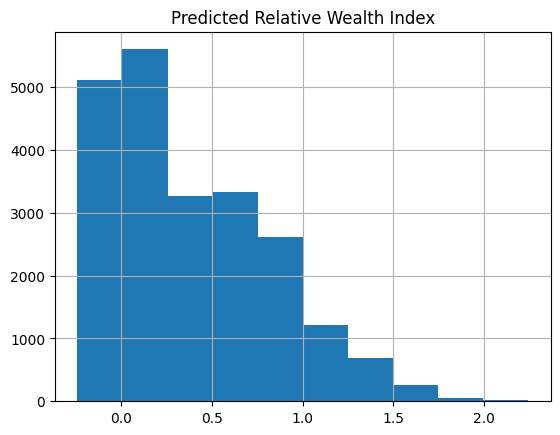

In [14]:
rollout_aoi[['Predicted Relative Wealth Index']].hist()

In [ ]:
rollout_aoi.explore(column='Predicted Relative Wealth Index')

The Predicted Relative Wealth Index map should look like this

![image info](2023-02-21-la-predicted-wealth-index.PNG)

In [16]:
rollout_aoi.head()

,quadkey,shapeName,shapeISO,shapeID,shapeGroup,shapeType,pop_count,geometry,Predicted Relative Wealth Index
0,13220113003212,Tonpheung,None,LAO-ADM2-3_0_0-B114,LAO,ADM2,1139.814456,"POLYGON ((100.06348 20.34463, 100.06348 20.365...",0.785608
1,13220113003211,Tonpheung,None,LAO-ADM2-3_0_0-B114,LAO,ADM2,18.897820,"POLYGON ((100.08545 20.36523, 100.08545 20.385...",1.346351
2,13220113003213,Tonpheung,None,LAO-ADM2-3_0_0-B114,LAO,ADM2,467.272466,"POLYGON ((100.08545 20.34463, 100.08545 20.365...",1.319193
3,13220113003231,Tonpheung,None,LAO-ADM2-3_0_0-B114,LAO,ADM2,457.210483,"POLYGON ((100.08545 20.32402, 100.08545 20.344...",1.380295
4,13220113003233,Tonpheung,None,LAO-ADM2-3_0_0-B114,LAO,ADM2,484.636913,"POLYGON ((100.08545 20.30342, 100.08545 20.324...",1.137876


In [17]:
rollout_aoi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22133 entries, 0 to 22132
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   quadkey                          22133 non-null  object  
 1   shapeName                        22133 non-null  object  
 2   shapeISO                         22133 non-null  object  
 3   shapeID                          22133 non-null  object  
 4   shapeGroup                       22133 non-null  object  
 5   shapeType                        22133 non-null  object  
 6   pop_count                        22133 non-null  float64 
 7   geometry                         22133 non-null  geometry
 8   Predicted Relative Wealth Index  22133 non-null  float64 
dtypes: float64(2), geometry(1), object(6)
memory usage: 1.5+ MB


## Binning predictions into wealth categories

Afterwards, we label the predicted relative wealth by binning them into 5 categories 

|Category |Description| 
|---|-----------------| 
| A | high income | 
| B | mid-high income | 
| C | middle income | 
| D | mid-low income | 
| E | low income |

We can create these wealth categories in two ways, both of which are provided in the output dataset. 
- `Predicted Wealth Category (quintile)`: Categories derived by splitting the output `Predicted Relative Wealth Index` distribution into 5 equally sized quintiles
- `Predicted Wealth Category (split-quintile)`: Categories derived using the **split quintiles** approach described below. This preserves the realities of unequal wealth distribution by accounting for distance from the mean wealth level `y = 0`. 

**Split-quintile approach**
1. Generate this by identifying two splits first, a) `Predicted Relative Wealth Index > 0` (above average wealth) and b) `Predicted Relative Wealth Index < 0` (below average wealth).
2. Generate quintiles for each of the two initial splits.
3. Take every 2 quintiles as one wealth bin.


![alt](../../../assets/split%20quintile%20approach.png)



### Calculate equal-quintile wealth category

In [18]:
rollout_aoi["Predicted Wealth Category (quintile)"] = categorize_wealth_index(
    rollout_aoi["Predicted Relative Wealth Index"], split_quantile=False
).astype(str)


In [ ]:
rollout_aoi.explore(
    column = 'Predicted Wealth Category (quintile)',
    cmap = 'viridis_r' # _r suffix reverses the colormap
)

### Calculate split-quintile wealth category

In [20]:
rollout_aoi["Predicted Wealth Category (split-quintile)"] = categorize_wealth_index(
    rollout_aoi["Predicted Relative Wealth Index"], split_quantile=True
)


[-0.23858605936507324, -0.07980970101347015, -0.03530702792083316, 0.07747829814510494, 0.6163853439803836, 2.2415549800587398]


In [ ]:
rollout_aoi.explore(
    column = 'Predicted Wealth Category (split-quintile)',
    cmap = 'viridis_r' # _r suffix reverses the colormap
)

## Save output

In [22]:
%%time
rollout_aoi.to_file(f'{rollout_date}-{country_code}-rollout-output.geojson', driver='GeoJSON', index=False)

CPU times: user 5.53 s, sys: 78.1 ms, total: 5.61 s
Wall time: 6.38 s
